In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb

from src.sanity import *

from src.load_datasets import (
    load_air_polution_data,
    load_air_quality_data,
    load_climate_change_data,
)

from src.utils import show_dataset, show_series, plot_metrics
from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
)

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
dataframe = load_air_polution_data()
print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

dataframe shape (43800, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  41757 non-null  float64
 2   dewp       43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB
None


,date,pollution,dewp,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
dataframe["date"] = pd.to_datetime(dataframe["date"])

dataframe.set_index(keys="date", inplace=True)

# dataframe.sort_values(by='date',inplace=True)
dataframe.sort_index(ascending=True)

dataframe["pollution"] = dataframe["pollution"].interpolate()

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe.resample("D").mean(numeric_only=True)

print(f"dataframe shape {dataframe.shape}")

dataframe shape (43800, 8)
dataframe shape (1825, 7)


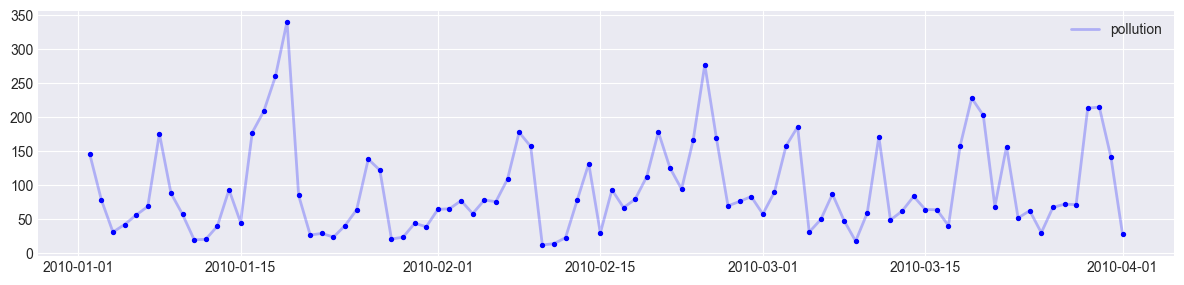

In [5]:
show_dataset(dataframe[:90], columns=["pollution"])

In [6]:
def test_train_split(dataframe: pd.DataFrame, test_size: int):
    dataframe_ = dataframe.copy(deep=True)
    if isinstance(dataframe_.index, pd.DatetimeIndex) is False:
        return
    dataframe_.sort_index(ascending=True)

    train_df = dataframe_[:-test_size].copy(deep=True)
    test_df = dataframe_[-test_size:].copy(deep=True)

    return train_df, test_df


train_data, test_data = test_train_split(dataframe, test_size=30)

print(f"Train Size : {train_data.shape}")
print(f"Test  Size : {test_data.shape} ")

Train Size : (1795, 7)
Test  Size : (30, 7) 


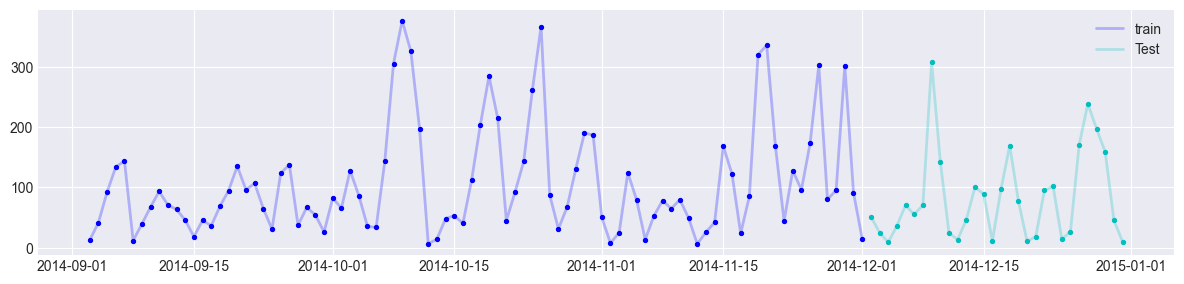

In [7]:
show_series(
    [train_data["pollution"][-90:], test_data["pollution"]], labels=["train", "Test"]
)

In [8]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "pollution"


def change_to_float(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe_ = dataframe.copy(deep=True)
    return dataframe_.astype(float)


train_data_feat = (
    train_data.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(change_to_float)
)

test_data_feat = (
    test_data.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(change_to_float)
)

print(f"train_data_feat shape {train_data_feat.shape}")
print(f"test_data_feat shape {test_data_feat.shape}")

test_data_feat.head()

train_data_feat shape (1795, 26)
test_data_feat shape (30, 26)


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,NaN,NaN,28.791667,...,2.0,49.0,0.0,1.0,0.909297,-0.416147,-0.536573,0.843854,0.149847,-0.988709
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,51.791667,NaN,28.791667,...,3.0,49.0,0.0,1.0,0.141120,-0.989992,-0.536573,0.843854,-0.751007,-0.660294
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,25.375000,51.791667,28.791667,...,4.0,49.0,0.0,1.0,-0.756802,-0.653644,-0.536573,0.843854,-0.961389,0.275192
2014-12-05,36.375000,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,9.208333,25.375000,23.652778,...,5.0,49.0,0.0,0.0,-0.958924,0.283662,-0.536573,0.843854,-0.287874,0.957668
2014-12-06,70.541667,-16.541667,-1.958333,1026.291667,4.210833,0.0,0.0,36.375000,9.208333,38.708333,...,6.0,49.0,1.0,0.0,-0.279415,0.960170,-0.536573,0.843854,0.650311,0.759668


In [9]:
train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data_feat shape {train_data_feat.shape}")
print(f"test_data_feat shape {test_data_feat.shape}")
print(train_data_feat.isna().sum().sum())
train_data_feat.head()

train_data_feat shape (1793, 26)
test_data_feat shape (30, 26)
0


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,78.833333,145.958333,85.375000,...,4.0,1.0,0.0,1.0,-0.756802,-0.653644,0.841471,0.540302,-0.756802,-0.653644
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.0,0.0,31.333333,78.833333,50.875000,...,5.0,1.0,0.0,1.0,-0.958924,0.283662,0.841471,0.540302,-0.958924,0.283662
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.0,0.0,42.458333,31.333333,43.402778,...,6.0,1.0,0.0,1.0,-0.279415,0.960170,0.841471,0.540302,-0.279415,0.960170
2010-01-07,69.000000,-21.250000,-12.500000,1034.083333,10.170000,0.0,0.0,56.416667,42.458333,55.958333,...,7.0,1.0,0.0,1.0,0.656987,0.753902,0.841471,0.540302,0.656987,0.753902
2010-01-08,176.208333,-17.125000,-11.708333,1028.000000,1.972917,0.0,0.0,69.000000,56.416667,100.541667,...,8.0,1.0,0.0,0.0,0.989358,-0.145500,0.841471,0.540302,0.989358,-0.145500


In [10]:
def seperate_target(dataframe: pd.DataFrame, target_columns: str):
    dataframe_ = dataframe.copy(deep=True)
    target_columns = (
        target_column if isinstance(target_columns, list) else [target_columns]
    )
    target = dataframe_[target_columns].copy(deep=True)

    for col in target_columns:
        dataframe_.pop(col)

    return dataframe_, target


train_x, train_y = seperate_target(train_data_feat, "pollution")
test_x, test_y = seperate_target(test_data_feat, "pollution")

print(train_x.isna().sum().sum())
print(f"Train Size {train_x.shape} {train_y.shape}")
print(f"Test Size {test_x.shape} {test_y.shape}")

0
Train Size (1793, 25) (1793, 1)
Test Size (30, 25) (30, 1)


In [11]:
# train_y.head()
# train_y.pollution.to_numpy()

In [12]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    return actual - predicted


def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)))


def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    return _error(actual, predicted) / (actual + EPSILON)


def mape(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_percentage_error(actual, predicted)))


METRICS = {"mae": mae, "rmse": rmse, "mape": mape, "r2": r2_score}


def evaluate(actual: np.ndarray, predicted: np.ndarray):
    results = {}
    metrics = ("mae", "rmse", "mape", "r2")
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

In [13]:
# resultsDF = pd.DataFrame(columns=['algo','mae','rmse','mape','r2'])
# pd.concat([resultsDF, pd.DataFrame.from_dict({'algo':'BayesianRidge',**result})])
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [37]:
model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.107 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.293 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.430 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.147 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.389 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.457 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.238 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.374 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.484 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.272 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.366 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

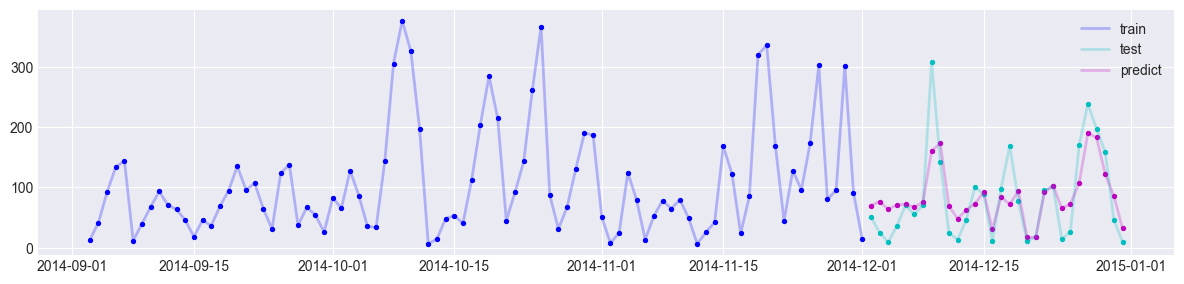

In [38]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [14]:
model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


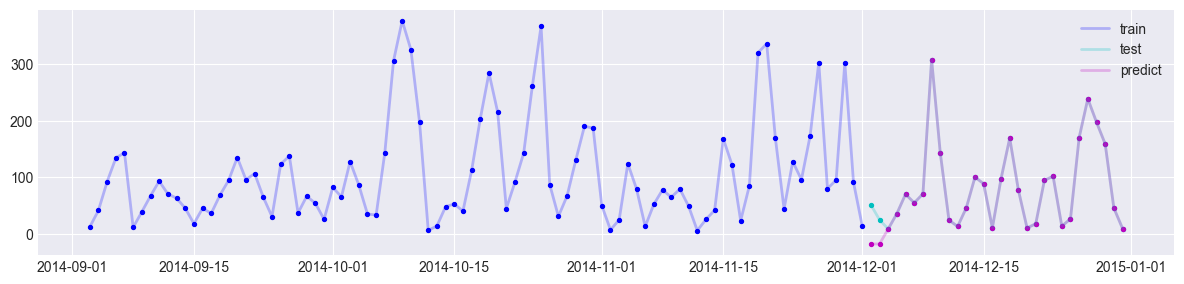

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [16]:
model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

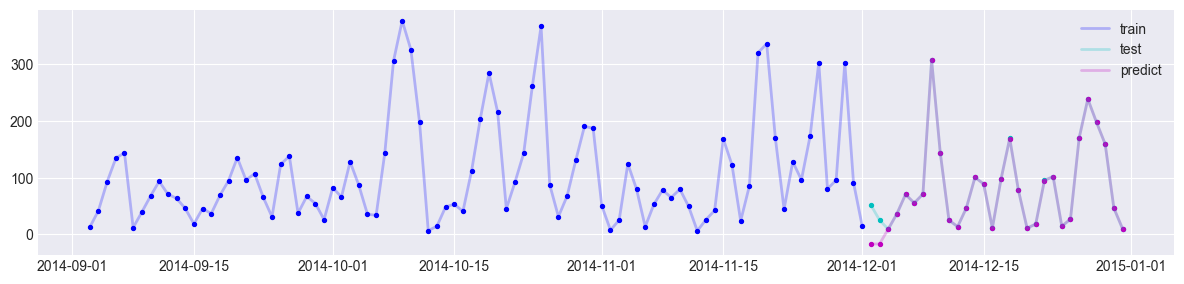

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [18]:
model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

# resultsDF.head()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.812 total time=   1.1s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.867 total time=   1.9s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.916 total time=   3.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.814 total time=   1.7s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.867 total time=   3.4s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.917 total time=   5.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.814 total time=   2.2s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.867 total time=   4.5s
[C

[CV 2/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.872 total time=   5.3s
[CV 3/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.923 total time=   7.4s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.820 total time=   1.3s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.880 total time=   3.2s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.930 total time=   4.2s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.823 total time=   2.6s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.880 total time=   4.6s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.930 total time=   6.6s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=

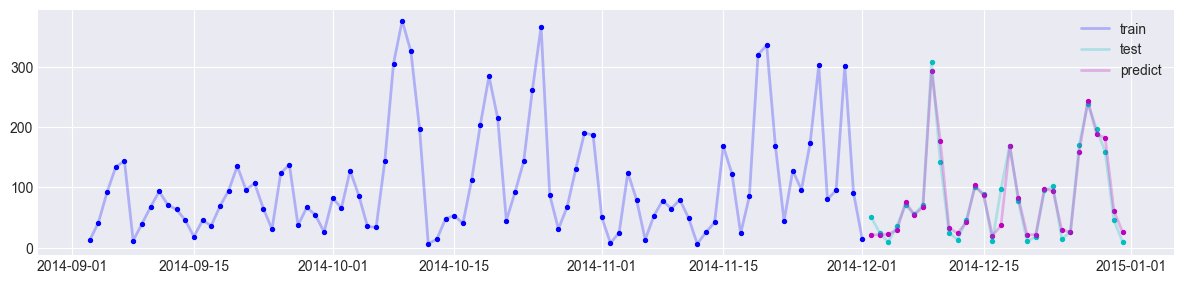

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.02985	validation_1-mae:81.73658
[1]	validation_0-mae:96.08425	validation_1-mae:80.98079
[2]	validation_0-mae:95.14682	validation_1-mae:80.20623
[3]	validation_0-mae:94.21994	validation_1-mae:79.47328
[4]	validation_0-mae:93.30037	validation_1-mae:78.71389
[5]	validation_0-mae:92.39062	validation_1-mae:77.94632
[6]	validation_0-mae:91.49137	validation_1-mae:77.21522
[7]	validation_0-mae:90.59839	validation_1-mae:76.43074
[8]	validation_0-mae:89.71562	validation_1-mae:75.67111
[9]	validation_0-mae:88.84196	validation_1-mae:74.97567
[10]	validation_0-mae:87.97741	validation_1-mae:74.26683
[11]	validation_0-mae:87.11801	validation_1-mae:73.55352
[12]	validation_0-mae:86.26645	validation_1-mae:72.91540
[13]	validation_0-mae:85.42854	validation_1-mae:72.28067
[14]	validation_0-mae:84.59440	validation_1-mae:71.56677
[15]	validation_0-mae:83.76860	validation_1-mae:70.95229
[16]	validation_0-mae:82.95129	validation_1-mae:70.24675
[17]	validation_0-mae:82.14500	validation

[144]	validation_0-mae:24.92815	validation_1-mae:25.60369
[145]	validation_0-mae:24.71296	validation_1-mae:25.41903
[146]	validation_0-mae:24.49865	validation_1-mae:25.20772
[147]	validation_0-mae:24.29099	validation_1-mae:25.03550
[148]	validation_0-mae:24.08353	validation_1-mae:24.84437
[149]	validation_0-mae:23.87090	validation_1-mae:24.66376
[150]	validation_0-mae:23.67053	validation_1-mae:24.51696
[151]	validation_0-mae:23.46764	validation_1-mae:24.34557
[152]	validation_0-mae:23.26609	validation_1-mae:24.18977
[153]	validation_0-mae:23.06213	validation_1-mae:24.01883
[154]	validation_0-mae:22.86209	validation_1-mae:23.85105
[155]	validation_0-mae:22.67257	validation_1-mae:23.70180
[156]	validation_0-mae:22.48038	validation_1-mae:23.53076
[157]	validation_0-mae:22.29158	validation_1-mae:23.35948
[158]	validation_0-mae:22.10188	validation_1-mae:23.20077
[159]	validation_0-mae:21.91171	validation_1-mae:23.05605
[160]	validation_0-mae:21.72633	validation_1-mae:22.89443
[161]	validati

[286]	validation_0-mae:8.61212	validation_1-mae:12.16357
[287]	validation_0-mae:8.56301	validation_1-mae:12.12068
[288]	validation_0-mae:8.51342	validation_1-mae:12.07405
[289]	validation_0-mae:8.46260	validation_1-mae:12.04132
[290]	validation_0-mae:8.41454	validation_1-mae:12.00448
[291]	validation_0-mae:8.36808	validation_1-mae:11.97180
[292]	validation_0-mae:8.31990	validation_1-mae:11.93387
[293]	validation_0-mae:8.27261	validation_1-mae:11.89777
[294]	validation_0-mae:8.22290	validation_1-mae:11.88565
[295]	validation_0-mae:8.17537	validation_1-mae:11.86111
[296]	validation_0-mae:8.12855	validation_1-mae:11.82927
[297]	validation_0-mae:8.07889	validation_1-mae:11.80607
[298]	validation_0-mae:8.03398	validation_1-mae:11.77434
[299]	validation_0-mae:7.98862	validation_1-mae:11.74006
[300]	validation_0-mae:7.94389	validation_1-mae:11.70989
[301]	validation_0-mae:7.90003	validation_1-mae:11.67714
[302]	validation_0-mae:7.85545	validation_1-mae:11.64937
[303]	validation_0-mae:7.81252	

[431]	validation_0-mae:4.43280	validation_1-mae:9.75958
[432]	validation_0-mae:4.41979	validation_1-mae:9.75170
[433]	validation_0-mae:4.40537	validation_1-mae:9.74763
[434]	validation_0-mae:4.38986	validation_1-mae:9.73893
[435]	validation_0-mae:4.37368	validation_1-mae:9.72814
[436]	validation_0-mae:4.35795	validation_1-mae:9.73055
[437]	validation_0-mae:4.34241	validation_1-mae:9.71870
[438]	validation_0-mae:4.32773	validation_1-mae:9.70846
[439]	validation_0-mae:4.31405	validation_1-mae:9.70149
[440]	validation_0-mae:4.30131	validation_1-mae:9.69415
[441]	validation_0-mae:4.28769	validation_1-mae:9.68596
[442]	validation_0-mae:4.27415	validation_1-mae:9.67784
[443]	validation_0-mae:4.25905	validation_1-mae:9.66351
[444]	validation_0-mae:4.24448	validation_1-mae:9.66414
[445]	validation_0-mae:4.22960	validation_1-mae:9.64874
[446]	validation_0-mae:4.21726	validation_1-mae:9.64197
[447]	validation_0-mae:4.20323	validation_1-mae:9.63660
[448]	validation_0-mae:4.18979	validation_1-mae:

[578]	validation_0-mae:3.09300	validation_1-mae:9.20769
[579]	validation_0-mae:3.08821	validation_1-mae:9.20635
[580]	validation_0-mae:3.08438	validation_1-mae:9.20655
[581]	validation_0-mae:3.07918	validation_1-mae:9.20738
[582]	validation_0-mae:3.07603	validation_1-mae:9.20418
[583]	validation_0-mae:3.07157	validation_1-mae:9.20198
[584]	validation_0-mae:3.06806	validation_1-mae:9.20022
[585]	validation_0-mae:3.06302	validation_1-mae:9.19891
[586]	validation_0-mae:3.05793	validation_1-mae:9.19771
[587]	validation_0-mae:3.05417	validation_1-mae:9.19795
[588]	validation_0-mae:3.04867	validation_1-mae:9.19850
[589]	validation_0-mae:3.04427	validation_1-mae:9.19641
[590]	validation_0-mae:3.03918	validation_1-mae:9.19512
[591]	validation_0-mae:3.03508	validation_1-mae:9.19193
[592]	validation_0-mae:3.03153	validation_1-mae:9.19024
[593]	validation_0-mae:3.02822	validation_1-mae:9.18846
[594]	validation_0-mae:3.02479	validation_1-mae:9.18679
[595]	validation_0-mae:3.02047	validation_1-mae:

[725]	validation_0-mae:2.51962	validation_1-mae:9.00573
[726]	validation_0-mae:2.51774	validation_1-mae:9.00310
[727]	validation_0-mae:2.51342	validation_1-mae:9.00808
[728]	validation_0-mae:2.50951	validation_1-mae:9.00598
[729]	validation_0-mae:2.50443	validation_1-mae:9.00193
[730]	validation_0-mae:2.50235	validation_1-mae:9.00086
[731]	validation_0-mae:2.49831	validation_1-mae:9.00145
[732]	validation_0-mae:2.49498	validation_1-mae:8.99753
[733]	validation_0-mae:2.49329	validation_1-mae:8.99589
[734]	validation_0-mae:2.48947	validation_1-mae:8.99158
[735]	validation_0-mae:2.48650	validation_1-mae:8.98796
[736]	validation_0-mae:2.48412	validation_1-mae:8.98978
[737]	validation_0-mae:2.48249	validation_1-mae:8.98857
[738]	validation_0-mae:2.47854	validation_1-mae:8.98668
[739]	validation_0-mae:2.47346	validation_1-mae:8.98749
[740]	validation_0-mae:2.47165	validation_1-mae:8.98426
[741]	validation_0-mae:2.46732	validation_1-mae:8.98101
[742]	validation_0-mae:2.46335	validation_1-mae:

[872]	validation_0-mae:2.09214	validation_1-mae:8.87880
[873]	validation_0-mae:2.08871	validation_1-mae:8.87589
[874]	validation_0-mae:2.08649	validation_1-mae:8.87583
[875]	validation_0-mae:2.08486	validation_1-mae:8.87598
[876]	validation_0-mae:2.08266	validation_1-mae:8.87566
[877]	validation_0-mae:2.08053	validation_1-mae:8.87544
[878]	validation_0-mae:2.07808	validation_1-mae:8.87786


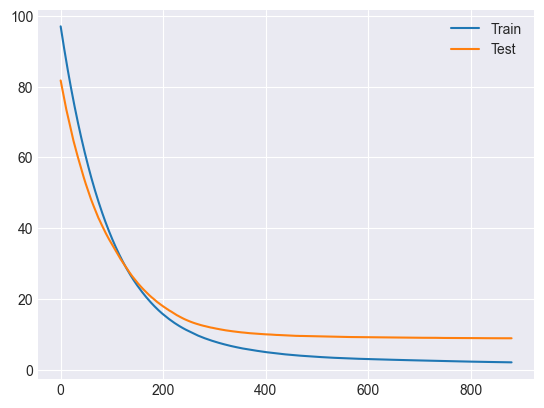

In [20]:
model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

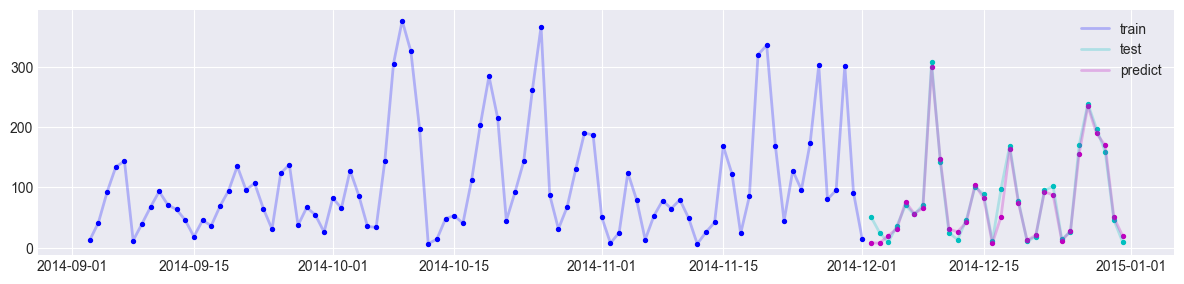

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [22]:
model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 52.5095	training's l2: 4939.95	valid_1's l1: 56.8644	valid_1's l2: 4809.58
[2]	training's l1: 48.0534	training's l2: 4156.14	valid_1's l1: 52.0665	valid_1's l2: 4016.17
[3]	training's l1: 44.0802	training's l2: 3512.92	valid_1's l1: 47.0091	valid_1's l2: 3285.29
[4]	training's l1: 40.5173	training's l2: 2983.46	valid_1's l1: 42.9576	valid_1's l2: 2755.07
[5]	training's l1: 37.3013	training's l2: 2537.45	valid_1's l1: 39.1995	valid_1's l2: 2317.06
[6]	training's l1: 34.3313	training's l2: 2166.91	valid_1's l1: 36.0037	valid_1's l2: 1973.45
[7]	training's l1: 31.7117	training's l2: 1861.88	valid_1's l1: 33.255	valid_1's l2: 1692.19
[8]	training's l1: 29.3456	training's l2: 1605.94	valid_1's l1: 30.8153	valid_1's l2: 1458.55
[9]	training's l1: 27.1229	training's l2: 1390.64	valid_1's l1: 28.8399	valid_1's l2: 1270.84
[10]	training's l1: 25.1655	training's l2: 1211.39	valid_1's l1: 26.7746	valid_1's l2: 1110.08
[11]	training's l1: 23.4516	training's l2: 1065.56	valid_1's

[96]	training's l1: 3.34177	training's l2: 37.9877	valid_1's l1: 9.25382	valid_1's l2: 178.936
[97]	training's l1: 3.3119	training's l2: 37.4751	valid_1's l1: 9.2518	valid_1's l2: 179.091
[98]	training's l1: 3.28274	training's l2: 36.8566	valid_1's l1: 9.26268	valid_1's l2: 179.241
[99]	training's l1: 3.25823	training's l2: 36.4083	valid_1's l1: 9.27047	valid_1's l2: 179.517
[100]	training's l1: 3.235	training's l2: 35.9875	valid_1's l1: 9.26186	valid_1's l2: 178.882


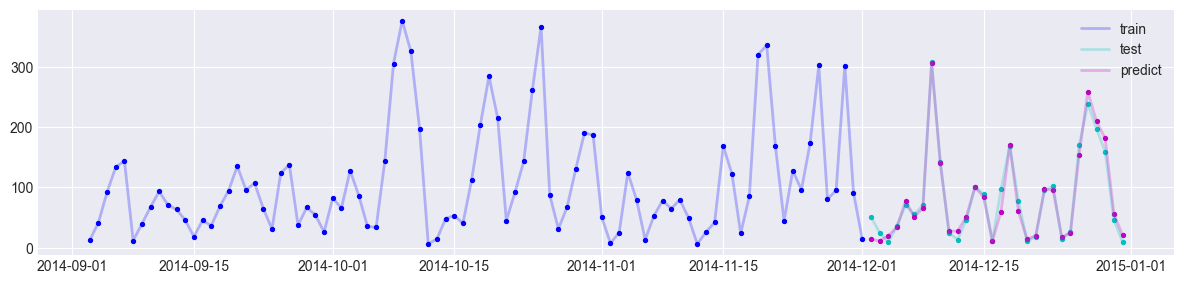

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [24]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 115.2649653	test: 119.2094318	best: 119.2094318 (0)	total: 151ms	remaining: 2m 30s
1:	learn: 107.0444915	test: 111.3805648	best: 111.3805648 (1)	total: 156ms	remaining: 1m 17s
2:	learn: 100.0313711	test: 104.4947107	best: 104.4947107 (2)	total: 158ms	remaining: 52.6s
3:	learn: 93.3912362	test: 97.7683861	best: 97.7683861 (3)	total: 160ms	remaining: 39.7s
4:	learn: 87.6934245	test: 92.4194709	best: 92.4194709 (4)	total: 161ms	remaining: 31.9s
5:	learn: 82.7293586	test: 87.0625555	best: 87.0625555 (5)	total: 165ms	remaining: 27.3s
6:	learn: 78.1308161	test: 82.0884286	best: 82.0884286 (6)	total: 168ms	remaining: 23.8s
7:	learn: 73.6581207	test: 77.3196315	best: 77.3196315 (7)	total: 171ms	remaining: 21.2s
8:	learn: 69.9563593	test: 73.2185355	best: 73.2185355 (8)	total: 178ms	remaining: 19.6s
9:	learn: 66.5359992	test: 69.8783462	best: 69.8783462 (9)	total: 191ms	remaining: 18.9s
10:	learn: 63.7246532	test: 67.2615348	best: 67.2615348 (10)	total: 205ms	remaining: 18.4s
11:	lear

99:	learn: 19.1779251	test: 22.7809719	best: 22.7809719 (99)	total: 1.24s	remaining: 11.2s
100:	learn: 18.9986240	test: 22.6896503	best: 22.6896503 (100)	total: 1.25s	remaining: 11.1s
101:	learn: 18.7762510	test: 22.5525437	best: 22.5525437 (101)	total: 1.25s	remaining: 11s
102:	learn: 18.5767718	test: 22.4203285	best: 22.4203285 (102)	total: 1.25s	remaining: 10.9s
103:	learn: 18.4571501	test: 22.3267304	best: 22.3267304 (103)	total: 1.25s	remaining: 10.8s
104:	learn: 18.2721092	test: 22.1714499	best: 22.1714499 (104)	total: 1.26s	remaining: 10.7s
105:	learn: 18.1970662	test: 22.1355871	best: 22.1355871 (105)	total: 1.26s	remaining: 10.6s
106:	learn: 18.0492719	test: 21.9994390	best: 21.9994390 (106)	total: 1.26s	remaining: 10.5s
107:	learn: 17.8587256	test: 21.8485869	best: 21.8485869 (107)	total: 1.26s	remaining: 10.4s
108:	learn: 17.7536048	test: 21.7862704	best: 21.7862704 (108)	total: 1.26s	remaining: 10.3s
109:	learn: 17.5800801	test: 21.6307702	best: 21.6307702 (109)	total: 1.26

217:	learn: 9.3394599	test: 15.5868647	best: 15.5868647 (217)	total: 2.31s	remaining: 8.27s
218:	learn: 9.3042246	test: 15.5713943	best: 15.5713943 (218)	total: 2.31s	remaining: 8.23s
219:	learn: 9.2503542	test: 15.5388798	best: 15.5388798 (219)	total: 2.31s	remaining: 8.19s
220:	learn: 9.2270751	test: 15.5304345	best: 15.5304345 (220)	total: 2.31s	remaining: 8.15s
221:	learn: 9.1892651	test: 15.5043324	best: 15.5043324 (221)	total: 2.32s	remaining: 8.12s
222:	learn: 9.1423980	test: 15.4674537	best: 15.4674537 (222)	total: 2.32s	remaining: 8.08s
223:	learn: 9.1129163	test: 15.4862803	best: 15.4674537 (222)	total: 2.32s	remaining: 8.04s
224:	learn: 9.0688450	test: 15.4536084	best: 15.4536084 (224)	total: 2.32s	remaining: 8s
225:	learn: 9.0252716	test: 15.4142256	best: 15.4142256 (225)	total: 2.32s	remaining: 7.96s
226:	learn: 8.9769203	test: 15.3654680	best: 15.3654680 (226)	total: 2.33s	remaining: 7.92s
227:	learn: 8.9532520	test: 15.3729505	best: 15.3654680 (226)	total: 2.33s	remainin

323:	learn: 6.3025888	test: 14.0709613	best: 14.0709613 (323)	total: 2.93s	remaining: 6.12s
324:	learn: 6.2725299	test: 14.0670908	best: 14.0670908 (324)	total: 2.94s	remaining: 6.1s
325:	learn: 6.2426225	test: 14.0527014	best: 14.0527014 (325)	total: 2.94s	remaining: 6.07s
326:	learn: 6.2243746	test: 14.0522713	best: 14.0522713 (326)	total: 2.94s	remaining: 6.05s
327:	learn: 6.2029345	test: 14.0503468	best: 14.0503468 (327)	total: 2.94s	remaining: 6.02s
328:	learn: 6.1774610	test: 14.0276032	best: 14.0276032 (328)	total: 2.94s	remaining: 6s
329:	learn: 6.1586696	test: 14.0167242	best: 14.0167242 (329)	total: 2.94s	remaining: 5.98s
330:	learn: 6.1395419	test: 14.0134679	best: 14.0134679 (330)	total: 2.94s	remaining: 5.95s
331:	learn: 6.1123082	test: 13.9920913	best: 13.9920913 (331)	total: 2.95s	remaining: 5.93s
332:	learn: 6.0951401	test: 13.9997587	best: 13.9920913 (331)	total: 2.95s	remaining: 5.91s
333:	learn: 6.0820039	test: 13.9876373	best: 13.9876373 (333)	total: 2.96s	remaining

453:	learn: 4.4435453	test: 13.2651855	best: 13.2651855 (453)	total: 3.54s	remaining: 4.25s
454:	learn: 4.4327796	test: 13.2550097	best: 13.2550097 (454)	total: 3.54s	remaining: 4.24s
455:	learn: 4.4243415	test: 13.2451080	best: 13.2451080 (455)	total: 3.54s	remaining: 4.22s
456:	learn: 4.4107707	test: 13.2370209	best: 13.2370209 (456)	total: 3.54s	remaining: 4.21s
457:	learn: 4.3985259	test: 13.2365136	best: 13.2365136 (457)	total: 3.54s	remaining: 4.19s
458:	learn: 4.3960711	test: 13.2394988	best: 13.2365136 (457)	total: 3.54s	remaining: 4.18s
459:	learn: 4.3849202	test: 13.2359165	best: 13.2359165 (459)	total: 3.54s	remaining: 4.16s
460:	learn: 4.3769582	test: 13.2325184	best: 13.2325184 (460)	total: 3.55s	remaining: 4.15s
461:	learn: 4.3704667	test: 13.2293740	best: 13.2293740 (461)	total: 3.55s	remaining: 4.13s
462:	learn: 4.3574356	test: 13.2270756	best: 13.2270756 (462)	total: 3.55s	remaining: 4.12s
463:	learn: 4.3479745	test: 13.2242520	best: 13.2242520 (463)	total: 3.55s	remai

588:	learn: 3.4519699	test: 12.9234193	best: 12.9234193 (588)	total: 4.14s	remaining: 2.89s
589:	learn: 3.4464944	test: 12.9204647	best: 12.9204647 (589)	total: 4.14s	remaining: 2.88s
590:	learn: 3.4418612	test: 12.9150807	best: 12.9150807 (590)	total: 4.14s	remaining: 2.87s
591:	learn: 3.4372336	test: 12.9192503	best: 12.9150807 (590)	total: 4.14s	remaining: 2.86s
592:	learn: 3.4308065	test: 12.9203261	best: 12.9150807 (590)	total: 4.15s	remaining: 2.85s
593:	learn: 3.4226253	test: 12.9160630	best: 12.9150807 (590)	total: 4.15s	remaining: 2.83s
594:	learn: 3.4185928	test: 12.9167941	best: 12.9150807 (590)	total: 4.15s	remaining: 2.83s
595:	learn: 3.4129865	test: 12.9197214	best: 12.9150807 (590)	total: 4.15s	remaining: 2.81s
596:	learn: 3.4065039	test: 12.9201741	best: 12.9150807 (590)	total: 4.15s	remaining: 2.8s
597:	learn: 3.3974571	test: 12.9237321	best: 12.9150807 (590)	total: 4.16s	remaining: 2.79s
598:	learn: 3.3925703	test: 12.9360993	best: 12.9150807 (590)	total: 4.16s	remain

699:	learn: 2.8824930	test: 12.8186536	best: 12.8186536 (699)	total: 5.23s	remaining: 2.24s
700:	learn: 2.8780171	test: 12.8185748	best: 12.8185748 (700)	total: 5.25s	remaining: 2.24s
701:	learn: 2.8730853	test: 12.8169892	best: 12.8169892 (701)	total: 5.26s	remaining: 2.23s
702:	learn: 2.8724307	test: 12.8165322	best: 12.8165322 (702)	total: 5.27s	remaining: 2.23s
703:	learn: 2.8663914	test: 12.8178290	best: 12.8165322 (702)	total: 5.28s	remaining: 2.22s
704:	learn: 2.8633054	test: 12.8184907	best: 12.8165322 (702)	total: 5.29s	remaining: 2.21s
705:	learn: 2.8612401	test: 12.8161192	best: 12.8161192 (705)	total: 5.31s	remaining: 2.21s
706:	learn: 2.8569896	test: 12.8152233	best: 12.8152233 (706)	total: 5.32s	remaining: 2.21s
707:	learn: 2.8537770	test: 12.8187957	best: 12.8152233 (706)	total: 5.34s	remaining: 2.2s
708:	learn: 2.8503651	test: 12.8195384	best: 12.8152233 (706)	total: 5.35s	remaining: 2.2s
709:	learn: 2.8467227	test: 12.8189085	best: 12.8152233 (706)	total: 5.37s	remaini

802:	learn: 2.4839431	test: 12.7133356	best: 12.7133356 (802)	total: 6.52s	remaining: 1.6s
803:	learn: 2.4805362	test: 12.7148995	best: 12.7133356 (802)	total: 6.53s	remaining: 1.59s
804:	learn: 2.4782002	test: 12.7152613	best: 12.7133356 (802)	total: 6.54s	remaining: 1.58s
805:	learn: 2.4749119	test: 12.7132799	best: 12.7132799 (805)	total: 6.55s	remaining: 1.58s
806:	learn: 2.4720347	test: 12.7143676	best: 12.7132799 (805)	total: 6.57s	remaining: 1.57s
807:	learn: 2.4675757	test: 12.7103688	best: 12.7103688 (807)	total: 6.58s	remaining: 1.56s
808:	learn: 2.4641988	test: 12.7109555	best: 12.7103688 (807)	total: 6.6s	remaining: 1.56s
809:	learn: 2.4611871	test: 12.7070287	best: 12.7070287 (809)	total: 6.61s	remaining: 1.55s
810:	learn: 2.4568955	test: 12.7061948	best: 12.7061948 (810)	total: 6.62s	remaining: 1.54s
811:	learn: 2.4540399	test: 12.7057748	best: 12.7057748 (811)	total: 6.66s	remaining: 1.54s
812:	learn: 2.4505429	test: 12.7081923	best: 12.7057748 (811)	total: 6.67s	remaini

930:	learn: 2.1249602	test: 12.6531697	best: 12.6531697 (930)	total: 7.16s	remaining: 530ms
931:	learn: 2.1236574	test: 12.6504687	best: 12.6504687 (931)	total: 7.16s	remaining: 522ms
932:	learn: 2.1214576	test: 12.6520758	best: 12.6504687 (931)	total: 7.16s	remaining: 514ms
933:	learn: 2.1185082	test: 12.6525955	best: 12.6504687 (931)	total: 7.16s	remaining: 506ms
934:	learn: 2.1161502	test: 12.6466281	best: 12.6466281 (934)	total: 7.16s	remaining: 498ms
935:	learn: 2.1152719	test: 12.6465668	best: 12.6465668 (935)	total: 7.16s	remaining: 490ms
936:	learn: 2.1117548	test: 12.6469993	best: 12.6465668 (935)	total: 7.16s	remaining: 482ms
937:	learn: 2.1081067	test: 12.6479640	best: 12.6465668 (935)	total: 7.17s	remaining: 474ms
938:	learn: 2.1054493	test: 12.6463272	best: 12.6463272 (938)	total: 7.17s	remaining: 466ms
939:	learn: 2.1026915	test: 12.6451643	best: 12.6451643 (939)	total: 7.17s	remaining: 458ms
940:	learn: 2.0992208	test: 12.6463303	best: 12.6451643 (939)	total: 7.17s	remai

49:	learn: 29.6133894	test: 32.3651443	best: 32.3651443 (49)	total: 172ms	remaining: 3.26s
50:	learn: 29.4242440	test: 32.2320299	best: 32.2320299 (50)	total: 173ms	remaining: 3.22s
51:	learn: 29.0105525	test: 31.7918062	best: 31.7918062 (51)	total: 174ms	remaining: 3.18s
52:	learn: 28.5194942	test: 31.2592192	best: 31.2592192 (52)	total: 176ms	remaining: 3.14s
53:	learn: 28.2577392	test: 30.9277680	best: 30.9277680 (53)	total: 178ms	remaining: 3.11s
54:	learn: 28.0129453	test: 30.6888064	best: 30.6888064 (54)	total: 179ms	remaining: 3.08s
55:	learn: 27.8351414	test: 30.4719276	best: 30.4719276 (55)	total: 181ms	remaining: 3.05s
56:	learn: 27.7409478	test: 30.3979595	best: 30.3979595 (56)	total: 182ms	remaining: 3.02s
57:	learn: 27.6078171	test: 30.2856427	best: 30.2856427 (57)	total: 185ms	remaining: 3s
58:	learn: 27.3084023	test: 29.9528026	best: 29.9528026 (58)	total: 186ms	remaining: 2.97s
59:	learn: 27.0912952	test: 29.7777954	best: 29.7777954 (59)	total: 188ms	remaining: 2.94s
60

176:	learn: 12.1738162	test: 17.4998575	best: 17.4998575 (176)	total: 793ms	remaining: 3.69s
177:	learn: 12.1361587	test: 17.4850800	best: 17.4850800 (177)	total: 794ms	remaining: 3.67s
178:	learn: 12.0958896	test: 17.4748664	best: 17.4748664 (178)	total: 795ms	remaining: 3.65s
179:	learn: 12.0228222	test: 17.4208966	best: 17.4208966 (179)	total: 797ms	remaining: 3.63s
180:	learn: 11.9750475	test: 17.4019736	best: 17.4019736 (180)	total: 800ms	remaining: 3.62s
181:	learn: 11.8941885	test: 17.3153932	best: 17.3153932 (181)	total: 802ms	remaining: 3.6s
182:	learn: 11.8203862	test: 17.2882396	best: 17.2882396 (182)	total: 804ms	remaining: 3.59s
183:	learn: 11.7706404	test: 17.2572686	best: 17.2572686 (183)	total: 806ms	remaining: 3.58s
184:	learn: 11.6962500	test: 17.2110900	best: 17.2110900 (184)	total: 808ms	remaining: 3.56s
185:	learn: 11.6490694	test: 17.1667518	best: 17.1667518 (185)	total: 809ms	remaining: 3.54s
186:	learn: 11.5947385	test: 17.1251121	best: 17.1251121 (186)	total: 8

268:	learn: 8.1942104	test: 15.1115179	best: 15.1115179 (268)	total: 1.2s	remaining: 3.26s
269:	learn: 8.1582448	test: 15.1058503	best: 15.1058503 (269)	total: 1.2s	remaining: 3.24s
270:	learn: 8.1272601	test: 15.0835873	best: 15.0835873 (270)	total: 1.2s	remaining: 3.23s
271:	learn: 8.0996602	test: 15.0657436	best: 15.0657436 (271)	total: 1.2s	remaining: 3.22s
272:	learn: 8.0740027	test: 15.0595447	best: 15.0595447 (272)	total: 1.2s	remaining: 3.2s
273:	learn: 8.0544831	test: 15.1012085	best: 15.0595447 (272)	total: 1.2s	remaining: 3.19s
274:	learn: 8.0283933	test: 15.0887827	best: 15.0595447 (272)	total: 1.21s	remaining: 3.18s
275:	learn: 7.9975827	test: 15.0631650	best: 15.0595447 (272)	total: 1.21s	remaining: 3.17s
276:	learn: 7.9718164	test: 15.0454536	best: 15.0454536 (276)	total: 1.21s	remaining: 3.16s
277:	learn: 7.9470350	test: 15.0310548	best: 15.0310548 (277)	total: 1.21s	remaining: 3.15s
278:	learn: 7.9290552	test: 15.0096529	best: 15.0096529 (278)	total: 1.22s	remaining: 3

376:	learn: 6.0548850	test: 13.9753299	best: 13.9753299 (376)	total: 1.61s	remaining: 2.66s
377:	learn: 6.0403205	test: 13.9725243	best: 13.9725243 (377)	total: 1.61s	remaining: 2.65s
378:	learn: 6.0195643	test: 13.9588989	best: 13.9588989 (378)	total: 1.61s	remaining: 2.64s
379:	learn: 6.0039788	test: 13.9538709	best: 13.9538709 (379)	total: 1.61s	remaining: 2.63s
380:	learn: 5.9852938	test: 13.9360420	best: 13.9360420 (380)	total: 1.62s	remaining: 2.63s
381:	learn: 5.9670368	test: 13.9205704	best: 13.9205704 (381)	total: 1.62s	remaining: 2.62s
382:	learn: 5.9482220	test: 13.9166485	best: 13.9166485 (382)	total: 1.62s	remaining: 2.61s
383:	learn: 5.9266530	test: 13.9150349	best: 13.9150349 (383)	total: 1.62s	remaining: 2.6s
384:	learn: 5.9080095	test: 13.9039151	best: 13.9039151 (384)	total: 1.62s	remaining: 2.59s
385:	learn: 5.8834913	test: 13.8900957	best: 13.8900957 (385)	total: 1.62s	remaining: 2.58s
386:	learn: 5.8646491	test: 13.8779501	best: 13.8779501 (386)	total: 1.63s	remain

505:	learn: 4.5154807	test: 13.3273354	best: 13.3273354 (505)	total: 2.01s	remaining: 1.96s
506:	learn: 4.5039001	test: 13.3148377	best: 13.3148377 (506)	total: 2.01s	remaining: 1.95s
507:	learn: 4.4952991	test: 13.3138160	best: 13.3138160 (507)	total: 2.01s	remaining: 1.95s
508:	learn: 4.4933520	test: 13.3116364	best: 13.3116364 (508)	total: 2.01s	remaining: 1.94s
509:	learn: 4.4869048	test: 13.3100141	best: 13.3100141 (509)	total: 2.01s	remaining: 1.93s
510:	learn: 4.4756957	test: 13.3085660	best: 13.3085660 (510)	total: 2.01s	remaining: 1.93s
511:	learn: 4.4667814	test: 13.3035765	best: 13.3035765 (511)	total: 2.02s	remaining: 1.92s
512:	learn: 4.4554096	test: 13.3021943	best: 13.3021943 (512)	total: 2.02s	remaining: 1.92s
513:	learn: 4.4453267	test: 13.3041185	best: 13.3021943 (512)	total: 2.02s	remaining: 1.91s
514:	learn: 4.4383876	test: 13.3045781	best: 13.3021943 (512)	total: 2.02s	remaining: 1.91s
515:	learn: 4.4313096	test: 13.3009432	best: 13.3009432 (515)	total: 2.03s	remai

642:	learn: 3.5597068	test: 12.9897801	best: 12.9897801 (642)	total: 2.61s	remaining: 1.45s
643:	learn: 3.5560062	test: 12.9892706	best: 12.9892706 (643)	total: 2.61s	remaining: 1.44s
644:	learn: 3.5492399	test: 12.9854022	best: 12.9854022 (644)	total: 2.61s	remaining: 1.44s
645:	learn: 3.5458084	test: 12.9850160	best: 12.9850160 (645)	total: 2.61s	remaining: 1.43s
646:	learn: 3.5426697	test: 12.9853466	best: 12.9850160 (645)	total: 2.61s	remaining: 1.43s
647:	learn: 3.5347742	test: 12.9818144	best: 12.9818144 (647)	total: 2.62s	remaining: 1.42s
648:	learn: 3.5304594	test: 12.9799721	best: 12.9799721 (648)	total: 2.62s	remaining: 1.42s
649:	learn: 3.5244603	test: 12.9772538	best: 12.9772538 (649)	total: 2.62s	remaining: 1.41s
650:	learn: 3.5202330	test: 12.9752855	best: 12.9752855 (650)	total: 2.62s	remaining: 1.41s
651:	learn: 3.5180598	test: 12.9752030	best: 12.9752030 (651)	total: 2.62s	remaining: 1.4s
652:	learn: 3.5117371	test: 12.9762230	best: 12.9752030 (651)	total: 2.62s	remain

738:	learn: 3.0867809	test: 12.8828177	best: 12.8828177 (738)	total: 3s	remaining: 1.06s
739:	learn: 3.0838449	test: 12.8783718	best: 12.8783718 (739)	total: 3.01s	remaining: 1.06s
740:	learn: 3.0792943	test: 12.8851667	best: 12.8783718 (739)	total: 3.01s	remaining: 1.05s
741:	learn: 3.0728726	test: 12.8871718	best: 12.8783718 (739)	total: 3.01s	remaining: 1.05s
742:	learn: 3.0682696	test: 12.8876741	best: 12.8783718 (739)	total: 3.01s	remaining: 1.04s
743:	learn: 3.0601453	test: 12.8860706	best: 12.8783718 (739)	total: 3.01s	remaining: 1.04s
744:	learn: 3.0595214	test: 12.8864808	best: 12.8783718 (739)	total: 3.01s	remaining: 1.03s
745:	learn: 3.0547356	test: 12.8859675	best: 12.8783718 (739)	total: 3.02s	remaining: 1.03s
746:	learn: 3.0467954	test: 12.8802498	best: 12.8783718 (739)	total: 3.02s	remaining: 1.02s
747:	learn: 3.0445493	test: 12.8828355	best: 12.8783718 (739)	total: 3.02s	remaining: 1.02s
748:	learn: 3.0388724	test: 12.8812716	best: 12.8783718 (739)	total: 3.02s	remainin

848:	learn: 2.7006749	test: 12.8094065	best: 12.8094065 (848)	total: 3.4s	remaining: 606ms
849:	learn: 2.6973021	test: 12.8107514	best: 12.8094065 (848)	total: 3.41s	remaining: 601ms
850:	learn: 2.6922990	test: 12.8072685	best: 12.8072685 (850)	total: 3.41s	remaining: 597ms
851:	learn: 2.6919018	test: 12.8074729	best: 12.8072685 (850)	total: 3.41s	remaining: 592ms
852:	learn: 2.6884553	test: 12.8040588	best: 12.8040588 (852)	total: 3.41s	remaining: 588ms
853:	learn: 2.6843614	test: 12.8000075	best: 12.8000075 (853)	total: 3.41s	remaining: 583ms
854:	learn: 2.6839965	test: 12.8002059	best: 12.8000075 (853)	total: 3.41s	remaining: 579ms
855:	learn: 2.6815850	test: 12.7991002	best: 12.7991002 (855)	total: 3.41s	remaining: 574ms
856:	learn: 2.6791039	test: 12.7965076	best: 12.7965076 (856)	total: 3.42s	remaining: 570ms
857:	learn: 2.6770434	test: 12.7960011	best: 12.7960011 (857)	total: 3.42s	remaining: 566ms
858:	learn: 2.6733802	test: 12.7913077	best: 12.7913077 (858)	total: 3.42s	remain

990:	learn: 2.2960316	test: 12.6902910	best: 12.6902910 (990)	total: 3.81s	remaining: 34.6ms
991:	learn: 2.2931911	test: 12.6898221	best: 12.6898221 (991)	total: 3.81s	remaining: 30.7ms
992:	learn: 2.2900047	test: 12.6904655	best: 12.6898221 (991)	total: 3.81s	remaining: 26.9ms
993:	learn: 2.2863356	test: 12.6853137	best: 12.6853137 (993)	total: 3.81s	remaining: 23ms
994:	learn: 2.2837266	test: 12.6847830	best: 12.6847830 (994)	total: 3.82s	remaining: 19.2ms
995:	learn: 2.2805508	test: 12.6844747	best: 12.6844747 (995)	total: 3.82s	remaining: 15.3ms
996:	learn: 2.2788726	test: 12.6849594	best: 12.6844747 (995)	total: 3.82s	remaining: 11.5ms
997:	learn: 2.2766293	test: 12.6847469	best: 12.6844747 (995)	total: 3.82s	remaining: 7.66ms
998:	learn: 2.2763925	test: 12.6844003	best: 12.6844003 (998)	total: 3.82s	remaining: 3.83ms
999:	learn: 2.2724413	test: 12.6852650	best: 12.6844003 (998)	total: 3.82s	remaining: 0us

bestTest = 12.68440027
bestIteration = 998

1:	loss: 12.6844003	best: 12.6

91:	learn: 20.5475855	test: 24.2176768	best: 24.2176768 (91)	total: 561ms	remaining: 5.54s
92:	learn: 20.3951792	test: 24.0542597	best: 24.0542597 (92)	total: 563ms	remaining: 5.49s
93:	learn: 20.2451160	test: 23.9188550	best: 23.9188550 (93)	total: 565ms	remaining: 5.44s
94:	learn: 19.9961587	test: 23.7251763	best: 23.7251763 (94)	total: 569ms	remaining: 5.42s
95:	learn: 19.8035615	test: 23.5676253	best: 23.5676253 (95)	total: 576ms	remaining: 5.42s
96:	learn: 19.6562422	test: 23.4940934	best: 23.4940934 (96)	total: 584ms	remaining: 5.44s
97:	learn: 19.4596261	test: 23.3328704	best: 23.3328704 (97)	total: 591ms	remaining: 5.44s
98:	learn: 19.3197835	test: 23.2713463	best: 23.2713463 (98)	total: 601ms	remaining: 5.47s
99:	learn: 19.1143621	test: 23.1096048	best: 23.1096048 (99)	total: 607ms	remaining: 5.47s
100:	learn: 18.9544725	test: 22.9859749	best: 22.9859749 (100)	total: 618ms	remaining: 5.5s
101:	learn: 18.7384105	test: 22.8100092	best: 22.8100092 (101)	total: 623ms	remaining: 5.

185:	learn: 11.1467886	test: 17.1679505	best: 17.1679505 (185)	total: 987ms	remaining: 4.32s
186:	learn: 11.1050578	test: 17.1331619	best: 17.1331619 (186)	total: 990ms	remaining: 4.3s
187:	learn: 11.0486745	test: 17.0967578	best: 17.0967578 (187)	total: 992ms	remaining: 4.28s
188:	learn: 10.9777690	test: 17.0258867	best: 17.0258867 (188)	total: 995ms	remaining: 4.27s
189:	learn: 10.9353321	test: 17.0062609	best: 17.0062609 (189)	total: 996ms	remaining: 4.25s
190:	learn: 10.8903923	test: 16.9777501	best: 16.9777501 (190)	total: 998ms	remaining: 4.23s
191:	learn: 10.8636452	test: 16.9633496	best: 16.9633496 (191)	total: 1s	remaining: 4.21s
192:	learn: 10.8122603	test: 16.9183059	best: 16.9183059 (192)	total: 1s	remaining: 4.19s
193:	learn: 10.7433008	test: 16.8629934	best: 16.8629934 (193)	total: 1s	remaining: 4.17s
194:	learn: 10.6751849	test: 16.8108825	best: 16.8108825 (194)	total: 1.01s	remaining: 4.15s
195:	learn: 10.6206407	test: 16.7440693	best: 16.7440693 (195)	total: 1.01s	rema

303:	learn: 7.0370277	test: 14.5118906	best: 14.5118906 (303)	total: 1.62s	remaining: 3.7s
304:	learn: 7.0220518	test: 14.5020056	best: 14.5020056 (304)	total: 1.63s	remaining: 3.72s
305:	learn: 6.9917605	test: 14.4938279	best: 14.4938279 (305)	total: 1.65s	remaining: 3.73s
306:	learn: 6.9573941	test: 14.4696213	best: 14.4696213 (306)	total: 1.65s	remaining: 3.73s
307:	learn: 6.9266871	test: 14.4508397	best: 14.4508397 (307)	total: 1.66s	remaining: 3.73s
308:	learn: 6.9080942	test: 14.4426697	best: 14.4426697 (308)	total: 1.67s	remaining: 3.73s
309:	learn: 6.8821062	test: 14.4421034	best: 14.4421034 (309)	total: 1.68s	remaining: 3.73s
310:	learn: 6.8508040	test: 14.4203893	best: 14.4203893 (310)	total: 1.69s	remaining: 3.75s
311:	learn: 6.8401764	test: 14.4178819	best: 14.4178819 (311)	total: 1.71s	remaining: 3.76s
312:	learn: 6.8141099	test: 14.4141327	best: 14.4141327 (312)	total: 1.72s	remaining: 3.77s
313:	learn: 6.7834012	test: 14.3989247	best: 14.3989247 (313)	total: 1.73s	remain

437:	learn: 4.7797495	test: 13.3861442	best: 13.3861442 (437)	total: 2.69s	remaining: 3.45s
438:	learn: 4.7612084	test: 13.3751275	best: 13.3751275 (438)	total: 2.69s	remaining: 3.43s
439:	learn: 4.7476700	test: 13.3774544	best: 13.3751275 (438)	total: 2.69s	remaining: 3.42s
440:	learn: 4.7379004	test: 13.3623954	best: 13.3623954 (440)	total: 2.69s	remaining: 3.41s
441:	learn: 4.7203481	test: 13.3551862	best: 13.3551862 (441)	total: 2.69s	remaining: 3.4s
442:	learn: 4.7099641	test: 13.3569759	best: 13.3551862 (441)	total: 2.69s	remaining: 3.39s
443:	learn: 4.6954628	test: 13.3482227	best: 13.3482227 (443)	total: 2.69s	remaining: 3.37s
444:	learn: 4.6870023	test: 13.3447577	best: 13.3447577 (444)	total: 2.69s	remaining: 3.36s
445:	learn: 4.6788371	test: 13.3301224	best: 13.3301224 (445)	total: 2.7s	remaining: 3.35s
446:	learn: 4.6691548	test: 13.3335942	best: 13.3301224 (445)	total: 2.7s	remaining: 3.34s
447:	learn: 4.6528484	test: 13.3261483	best: 13.3261483 (447)	total: 2.7s	remaining

548:	learn: 3.7565177	test: 13.0254006	best: 13.0254006 (548)	total: 3.31s	remaining: 2.72s
549:	learn: 3.7489635	test: 13.0231511	best: 13.0231511 (549)	total: 3.32s	remaining: 2.72s
550:	learn: 3.7354496	test: 13.0124337	best: 13.0124337 (550)	total: 3.33s	remaining: 2.72s
551:	learn: 3.7298080	test: 13.0081644	best: 13.0081644 (551)	total: 3.35s	remaining: 2.71s
552:	learn: 3.7257992	test: 13.0046839	best: 13.0046839 (552)	total: 3.35s	remaining: 2.71s
553:	learn: 3.7162616	test: 13.0067716	best: 13.0046839 (552)	total: 3.36s	remaining: 2.71s
554:	learn: 3.7037073	test: 13.0099891	best: 13.0046839 (552)	total: 3.37s	remaining: 2.7s
555:	learn: 3.6936182	test: 13.0075779	best: 13.0046839 (552)	total: 3.38s	remaining: 2.7s
556:	learn: 3.6867568	test: 13.0069097	best: 13.0046839 (552)	total: 3.39s	remaining: 2.7s
557:	learn: 3.6793741	test: 13.0072619	best: 13.0046839 (552)	total: 3.4s	remaining: 2.7s
558:	learn: 3.6738146	test: 13.0096978	best: 13.0046839 (552)	total: 3.42s	remaining:

640:	learn: 3.1485889	test: 12.8097479	best: 12.8073276 (639)	total: 3.92s	remaining: 2.19s
641:	learn: 3.1427903	test: 12.8090208	best: 12.8073276 (639)	total: 3.92s	remaining: 2.19s
642:	learn: 3.1374659	test: 12.8121479	best: 12.8073276 (639)	total: 3.92s	remaining: 2.18s
643:	learn: 3.1363243	test: 12.8072214	best: 12.8072214 (643)	total: 3.93s	remaining: 2.17s
644:	learn: 3.1293372	test: 12.8054296	best: 12.8054296 (644)	total: 3.94s	remaining: 2.17s
645:	learn: 3.1270200	test: 12.8032421	best: 12.8032421 (645)	total: 3.95s	remaining: 2.17s
646:	learn: 3.1209091	test: 12.7994455	best: 12.7994455 (646)	total: 3.96s	remaining: 2.16s
647:	learn: 3.1166753	test: 12.7969925	best: 12.7969925 (647)	total: 3.96s	remaining: 2.15s
648:	learn: 3.1092690	test: 12.7961767	best: 12.7961767 (648)	total: 3.96s	remaining: 2.14s
649:	learn: 3.1027570	test: 12.7944724	best: 12.7944724 (649)	total: 3.97s	remaining: 2.14s
650:	learn: 3.0988702	test: 12.7935115	best: 12.7935115 (650)	total: 3.97s	remai

747:	learn: 2.6154600	test: 12.6570769	best: 12.6570769 (747)	total: 4.97s	remaining: 1.68s
748:	learn: 2.6121041	test: 12.6564640	best: 12.6564640 (748)	total: 4.98s	remaining: 1.67s
749:	learn: 2.6070580	test: 12.6558628	best: 12.6558628 (749)	total: 4.99s	remaining: 1.66s
750:	learn: 2.6044355	test: 12.6526169	best: 12.6526169 (750)	total: 5s	remaining: 1.66s
751:	learn: 2.6006397	test: 12.6524587	best: 12.6524587 (751)	total: 5s	remaining: 1.65s
752:	learn: 2.5963503	test: 12.6522307	best: 12.6522307 (752)	total: 5.01s	remaining: 1.64s
753:	learn: 2.5930328	test: 12.6470332	best: 12.6470332 (753)	total: 5.01s	remaining: 1.64s
754:	learn: 2.5898231	test: 12.6454208	best: 12.6454208 (754)	total: 5.02s	remaining: 1.63s
755:	learn: 2.5860083	test: 12.6452346	best: 12.6452346 (755)	total: 5.02s	remaining: 1.62s
756:	learn: 2.5807478	test: 12.6406483	best: 12.6406483 (756)	total: 5.03s	remaining: 1.61s
757:	learn: 2.5767737	test: 12.6358328	best: 12.6358328 (757)	total: 5.03s	remaining: 

855:	learn: 2.2150036	test: 12.5435550	best: 12.5415638 (854)	total: 6.03s	remaining: 1.01s
856:	learn: 2.2117858	test: 12.5421007	best: 12.5415638 (854)	total: 6.04s	remaining: 1.01s
857:	learn: 2.2087134	test: 12.5398217	best: 12.5398217 (857)	total: 6.05s	remaining: 1s
858:	learn: 2.2063552	test: 12.5394138	best: 12.5394138 (858)	total: 6.06s	remaining: 995ms
859:	learn: 2.2034499	test: 12.5379149	best: 12.5379149 (859)	total: 6.07s	remaining: 989ms
860:	learn: 2.1999760	test: 12.5372202	best: 12.5372202 (860)	total: 6.08s	remaining: 982ms
861:	learn: 2.1967507	test: 12.5370185	best: 12.5370185 (861)	total: 6.09s	remaining: 975ms
862:	learn: 2.1935279	test: 12.5356458	best: 12.5356458 (862)	total: 6.1s	remaining: 968ms
863:	learn: 2.1920157	test: 12.5331627	best: 12.5331627 (863)	total: 6.11s	remaining: 961ms
864:	learn: 2.1903890	test: 12.5325651	best: 12.5325651 (864)	total: 6.12s	remaining: 956ms
865:	learn: 2.1876942	test: 12.5329848	best: 12.5325651 (864)	total: 6.13s	remaining

964:	learn: 1.8955893	test: 12.4764334	best: 12.4755704 (961)	total: 7.1s	remaining: 257ms
965:	learn: 1.8916171	test: 12.4757744	best: 12.4755704 (961)	total: 7.1s	remaining: 250ms
966:	learn: 1.8885078	test: 12.4748652	best: 12.4748652 (966)	total: 7.1s	remaining: 242ms
967:	learn: 1.8858288	test: 12.4739922	best: 12.4739922 (967)	total: 7.1s	remaining: 235ms
968:	learn: 1.8842665	test: 12.4736759	best: 12.4736759 (968)	total: 7.1s	remaining: 227ms
969:	learn: 1.8817405	test: 12.4717041	best: 12.4717041 (969)	total: 7.11s	remaining: 220ms
970:	learn: 1.8786474	test: 12.4709108	best: 12.4709108 (970)	total: 7.11s	remaining: 212ms
971:	learn: 1.8756569	test: 12.4713296	best: 12.4709108 (970)	total: 7.11s	remaining: 205ms
972:	learn: 1.8722796	test: 12.4715456	best: 12.4709108 (970)	total: 7.11s	remaining: 197ms
973:	learn: 1.8707100	test: 12.4713119	best: 12.4709108 (970)	total: 7.11s	remaining: 190ms
974:	learn: 1.8687956	test: 12.4711026	best: 12.4709108 (970)	total: 7.11s	remaining:

56:	learn: 26.1312011	test: 35.6282304	best: 35.6282304 (56)	total: 660ms	remaining: 10.9s
57:	learn: 26.0378957	test: 35.4643483	best: 35.4643483 (57)	total: 674ms	remaining: 11s
58:	learn: 25.8449961	test: 35.4088484	best: 35.4088484 (58)	total: 688ms	remaining: 11s
59:	learn: 25.6836051	test: 35.2945824	best: 35.2945824 (59)	total: 700ms	remaining: 11s
60:	learn: 25.4686455	test: 35.1479131	best: 35.1479131 (60)	total: 711ms	remaining: 10.9s
61:	learn: 25.1419950	test: 34.7809787	best: 34.7809787 (61)	total: 720ms	remaining: 10.9s
62:	learn: 24.8016053	test: 34.4172084	best: 34.4172084 (62)	total: 728ms	remaining: 10.8s
63:	learn: 24.7428614	test: 34.3706036	best: 34.3706036 (63)	total: 735ms	remaining: 10.8s
64:	learn: 24.5337013	test: 34.1974235	best: 34.1974235 (64)	total: 743ms	remaining: 10.7s
65:	learn: 24.3226440	test: 34.0467469	best: 34.0467469 (65)	total: 751ms	remaining: 10.6s
66:	learn: 23.9935786	test: 33.7027620	best: 33.7027620 (66)	total: 768ms	remaining: 10.7s
67:	l

150:	learn: 12.0871659	test: 24.3211727	best: 24.3211727 (150)	total: 1.74s	remaining: 9.8s
151:	learn: 12.0195810	test: 24.2919791	best: 24.2919791 (151)	total: 1.75s	remaining: 9.79s
152:	learn: 11.9370319	test: 24.2358017	best: 24.2358017 (152)	total: 1.77s	remaining: 9.78s
153:	learn: 11.8753752	test: 24.1425346	best: 24.1425346 (153)	total: 1.78s	remaining: 9.76s
154:	learn: 11.7827277	test: 24.0991624	best: 24.0991624 (154)	total: 1.78s	remaining: 9.72s
155:	learn: 11.6868773	test: 24.0233728	best: 24.0233728 (155)	total: 1.79s	remaining: 9.7s
156:	learn: 11.6192729	test: 23.9864414	best: 23.9864414 (156)	total: 1.8s	remaining: 9.68s
157:	learn: 11.5358274	test: 23.9346914	best: 23.9346914 (157)	total: 1.82s	remaining: 9.7s
158:	learn: 11.4721507	test: 23.9121313	best: 23.9121313 (158)	total: 1.83s	remaining: 9.7s
159:	learn: 11.4012397	test: 23.8426372	best: 23.8426372 (159)	total: 1.84s	remaining: 9.69s
160:	learn: 11.3486936	test: 23.8119317	best: 23.8119317 (160)	total: 1.86s

247:	learn: 7.6901653	test: 21.2051047	best: 21.2051047 (247)	total: 2.83s	remaining: 8.59s
248:	learn: 7.6564649	test: 21.1977155	best: 21.1977155 (248)	total: 2.83s	remaining: 8.55s
249:	learn: 7.6118814	test: 21.1769342	best: 21.1769342 (249)	total: 2.84s	remaining: 8.51s
250:	learn: 7.5791863	test: 21.1195664	best: 21.1195664 (250)	total: 2.84s	remaining: 8.47s
251:	learn: 7.5614652	test: 21.1030004	best: 21.1030004 (251)	total: 2.84s	remaining: 8.44s
252:	learn: 7.5234066	test: 21.0949229	best: 21.0949229 (252)	total: 2.85s	remaining: 8.41s
253:	learn: 7.5043249	test: 21.0902573	best: 21.0902573 (253)	total: 2.85s	remaining: 8.38s
254:	learn: 7.4768576	test: 21.0401396	best: 21.0401396 (254)	total: 2.86s	remaining: 8.35s
255:	learn: 7.4368752	test: 21.0277572	best: 21.0277572 (255)	total: 2.86s	remaining: 8.32s
256:	learn: 7.4026096	test: 21.0217331	best: 21.0217331 (256)	total: 2.87s	remaining: 8.28s
257:	learn: 7.3644422	test: 21.0032004	best: 21.0032004 (257)	total: 2.87s	remai

347:	learn: 5.5730316	test: 20.0446707	best: 20.0446707 (347)	total: 3.47s	remaining: 6.5s
348:	learn: 5.5540557	test: 20.0303797	best: 20.0303797 (348)	total: 3.48s	remaining: 6.49s
349:	learn: 5.5406570	test: 20.0254697	best: 20.0254697 (349)	total: 3.49s	remaining: 6.48s
350:	learn: 5.5249257	test: 20.0080290	best: 20.0080290 (350)	total: 3.5s	remaining: 6.47s
351:	learn: 5.5103723	test: 20.0281497	best: 20.0080290 (350)	total: 3.51s	remaining: 6.46s
352:	learn: 5.4905713	test: 20.0514801	best: 20.0080290 (350)	total: 3.52s	remaining: 6.45s
353:	learn: 5.4729925	test: 20.0429877	best: 20.0080290 (350)	total: 3.52s	remaining: 6.43s
354:	learn: 5.4566512	test: 20.0383349	best: 20.0080290 (350)	total: 3.53s	remaining: 6.41s
355:	learn: 5.4457378	test: 20.0358172	best: 20.0080290 (350)	total: 3.54s	remaining: 6.4s
356:	learn: 5.4361443	test: 20.0059349	best: 20.0059349 (356)	total: 3.54s	remaining: 6.38s
357:	learn: 5.4133139	test: 20.0012021	best: 20.0012021 (357)	total: 3.55s	remainin

449:	learn: 4.3472561	test: 19.5872709	best: 19.5872709 (449)	total: 4.51s	remaining: 5.51s
450:	learn: 4.3376265	test: 19.5840623	best: 19.5840623 (450)	total: 4.52s	remaining: 5.5s
451:	learn: 4.3315271	test: 19.5861728	best: 19.5840623 (450)	total: 4.53s	remaining: 5.5s
452:	learn: 4.3293202	test: 19.5862100	best: 19.5840623 (450)	total: 4.54s	remaining: 5.49s
453:	learn: 4.3192452	test: 19.5841878	best: 19.5840623 (450)	total: 4.55s	remaining: 5.47s
454:	learn: 4.3083629	test: 19.5811477	best: 19.5811477 (454)	total: 4.56s	remaining: 5.46s
455:	learn: 4.2938217	test: 19.5776360	best: 19.5776360 (455)	total: 4.57s	remaining: 5.45s
456:	learn: 4.2834343	test: 19.5699966	best: 19.5699966 (456)	total: 4.59s	remaining: 5.45s
457:	learn: 4.2677649	test: 19.5697622	best: 19.5697622 (457)	total: 4.6s	remaining: 5.44s
458:	learn: 4.2595451	test: 19.5538162	best: 19.5538162 (458)	total: 4.61s	remaining: 5.44s
459:	learn: 4.2492260	test: 19.5525482	best: 19.5525482 (459)	total: 4.63s	remainin

552:	learn: 3.4981224	test: 19.3567224	best: 19.3567224 (552)	total: 5.58s	remaining: 4.51s
553:	learn: 3.4883516	test: 19.3532889	best: 19.3532889 (553)	total: 5.59s	remaining: 4.5s
554:	learn: 3.4827845	test: 19.3559471	best: 19.3532889 (553)	total: 5.6s	remaining: 4.49s
555:	learn: 3.4743759	test: 19.3558547	best: 19.3532889 (553)	total: 5.61s	remaining: 4.48s
556:	learn: 3.4665238	test: 19.3538035	best: 19.3532889 (553)	total: 5.62s	remaining: 4.47s
557:	learn: 3.4561792	test: 19.3502989	best: 19.3502989 (557)	total: 5.63s	remaining: 4.46s
558:	learn: 3.4489280	test: 19.3499838	best: 19.3499838 (558)	total: 5.64s	remaining: 4.45s
559:	learn: 3.4432489	test: 19.3487970	best: 19.3487970 (559)	total: 5.65s	remaining: 4.44s
560:	learn: 3.4382366	test: 19.3458112	best: 19.3458112 (560)	total: 5.67s	remaining: 4.43s
561:	learn: 3.4336969	test: 19.3419160	best: 19.3419160 (561)	total: 5.68s	remaining: 4.43s
562:	learn: 3.4273893	test: 19.3420225	best: 19.3419160 (561)	total: 5.69s	remaini

654:	learn: 2.8934683	test: 19.2068363	best: 19.2065990 (652)	total: 6.65s	remaining: 3.5s
655:	learn: 2.8880627	test: 19.2057987	best: 19.2057987 (655)	total: 6.66s	remaining: 3.49s
656:	learn: 2.8834648	test: 19.2057062	best: 19.2057062 (656)	total: 6.67s	remaining: 3.48s
657:	learn: 2.8823673	test: 19.2054672	best: 19.2054672 (657)	total: 6.68s	remaining: 3.47s
658:	learn: 2.8790746	test: 19.1983854	best: 19.1983854 (658)	total: 6.69s	remaining: 3.46s
659:	learn: 2.8759344	test: 19.1992645	best: 19.1983854 (658)	total: 6.7s	remaining: 3.45s
660:	learn: 2.8748823	test: 19.1983970	best: 19.1983854 (658)	total: 6.71s	remaining: 3.44s
661:	learn: 2.8703026	test: 19.1951262	best: 19.1951262 (661)	total: 6.72s	remaining: 3.43s
662:	learn: 2.8656169	test: 19.1959232	best: 19.1951262 (661)	total: 6.74s	remaining: 3.42s
663:	learn: 2.8600266	test: 19.1924380	best: 19.1924380 (663)	total: 6.75s	remaining: 3.42s
664:	learn: 2.8584734	test: 19.1940557	best: 19.1924380 (663)	total: 6.76s	remaini

754:	learn: 2.4899183	test: 19.0968388	best: 19.0968388 (754)	total: 7.7s	remaining: 2.5s
755:	learn: 2.4865951	test: 19.0977406	best: 19.0968388 (754)	total: 7.71s	remaining: 2.49s
756:	learn: 2.4802601	test: 19.0974929	best: 19.0968388 (754)	total: 7.71s	remaining: 2.48s
757:	learn: 2.4766522	test: 19.0998811	best: 19.0968388 (754)	total: 7.72s	remaining: 2.46s
758:	learn: 2.4737365	test: 19.0999776	best: 19.0968388 (754)	total: 7.73s	remaining: 2.45s
759:	learn: 2.4706243	test: 19.0970506	best: 19.0968388 (754)	total: 7.75s	remaining: 2.45s
760:	learn: 2.4688845	test: 19.0974084	best: 19.0968388 (754)	total: 7.76s	remaining: 2.44s
761:	learn: 2.4635502	test: 19.0961026	best: 19.0961026 (761)	total: 7.77s	remaining: 2.43s
762:	learn: 2.4570089	test: 19.0948492	best: 19.0948492 (762)	total: 7.79s	remaining: 2.42s
763:	learn: 2.4514047	test: 19.0976964	best: 19.0948492 (762)	total: 7.8s	remaining: 2.41s
764:	learn: 2.4472689	test: 19.0956618	best: 19.0948492 (762)	total: 7.81s	remainin

855:	learn: 2.1355586	test: 19.0335987	best: 19.0334757 (837)	total: 8.55s	remaining: 1.44s
856:	learn: 2.1318053	test: 19.0339343	best: 19.0334757 (837)	total: 8.57s	remaining: 1.43s
857:	learn: 2.1290917	test: 19.0340693	best: 19.0334757 (837)	total: 8.58s	remaining: 1.42s
858:	learn: 2.1259053	test: 19.0341897	best: 19.0334757 (837)	total: 8.59s	remaining: 1.41s
859:	learn: 2.1227811	test: 19.0333632	best: 19.0333632 (859)	total: 8.61s	remaining: 1.4s
860:	learn: 2.1218156	test: 19.0328863	best: 19.0328863 (860)	total: 8.62s	remaining: 1.39s
861:	learn: 2.1207260	test: 19.0306913	best: 19.0306913 (861)	total: 8.62s	remaining: 1.38s
862:	learn: 2.1142862	test: 19.0288906	best: 19.0288906 (862)	total: 8.64s	remaining: 1.37s
863:	learn: 2.1103397	test: 19.0290489	best: 19.0288906 (862)	total: 8.65s	remaining: 1.36s
864:	learn: 2.1076231	test: 19.0275223	best: 19.0275223 (864)	total: 8.66s	remaining: 1.35s
865:	learn: 2.1050921	test: 19.0268658	best: 19.0268658 (865)	total: 8.67s	remain

990:	learn: 1.7745178	test: 18.9679045	best: 18.9679045 (990)	total: 9.38s	remaining: 85.1ms
991:	learn: 1.7741734	test: 18.9670644	best: 18.9670644 (991)	total: 9.38s	remaining: 75.6ms
992:	learn: 1.7723509	test: 18.9676608	best: 18.9670644 (991)	total: 9.38s	remaining: 66.2ms
993:	learn: 1.7706112	test: 18.9675829	best: 18.9670644 (991)	total: 9.39s	remaining: 56.7ms
994:	learn: 1.7682943	test: 18.9674018	best: 18.9670644 (991)	total: 9.39s	remaining: 47.2ms
995:	learn: 1.7669568	test: 18.9674609	best: 18.9670644 (991)	total: 9.4s	remaining: 37.7ms
996:	learn: 1.7655238	test: 18.9669234	best: 18.9669234 (996)	total: 9.4s	remaining: 28.3ms
997:	learn: 1.7640072	test: 18.9668468	best: 18.9668468 (997)	total: 9.41s	remaining: 18.8ms
998:	learn: 1.7635222	test: 18.9672352	best: 18.9668468 (997)	total: 9.41s	remaining: 9.42ms
999:	learn: 1.7611360	test: 18.9669638	best: 18.9668468 (997)	total: 9.41s	remaining: 0us

bestTest = 18.96684677
bestIteration = 997

Training on fold [2/3]
0:	lear

100:	learn: 18.7310139	test: 22.6106975	best: 22.6106975 (100)	total: 542ms	remaining: 4.82s
101:	learn: 18.5823986	test: 22.5008698	best: 22.5008698 (101)	total: 555ms	remaining: 4.88s
102:	learn: 18.4098855	test: 22.3327870	best: 22.3327870 (102)	total: 568ms	remaining: 4.95s
103:	learn: 18.3106355	test: 22.2953183	best: 22.2953183 (103)	total: 582ms	remaining: 5.01s
104:	learn: 18.1885809	test: 22.2144961	best: 22.2144961 (104)	total: 594ms	remaining: 5.06s
105:	learn: 18.0858187	test: 22.1165205	best: 22.1165205 (105)	total: 606ms	remaining: 5.11s
106:	learn: 17.9890390	test: 22.0417493	best: 22.0417493 (106)	total: 619ms	remaining: 5.16s
107:	learn: 17.8347895	test: 21.8946104	best: 21.8946104 (107)	total: 631ms	remaining: 5.21s
108:	learn: 17.6348518	test: 21.7177904	best: 21.7177904 (108)	total: 639ms	remaining: 5.22s
109:	learn: 17.4549312	test: 21.5729964	best: 21.5729964 (109)	total: 645ms	remaining: 5.22s
110:	learn: 17.3217431	test: 21.4850390	best: 21.4850390 (110)	total: 

206:	learn: 9.9837937	test: 16.2847439	best: 16.2668876 (204)	total: 1.64s	remaining: 6.27s
207:	learn: 9.9640533	test: 16.2760750	best: 16.2668876 (204)	total: 1.64s	remaining: 6.26s
208:	learn: 9.9294055	test: 16.2661807	best: 16.2661807 (208)	total: 1.66s	remaining: 6.27s
209:	learn: 9.8967749	test: 16.2538138	best: 16.2538138 (209)	total: 1.67s	remaining: 6.29s
210:	learn: 9.8404520	test: 16.2285379	best: 16.2285379 (210)	total: 1.69s	remaining: 6.31s
211:	learn: 9.7848646	test: 16.1872727	best: 16.1872727 (211)	total: 1.7s	remaining: 6.32s
212:	learn: 9.7513934	test: 16.1701200	best: 16.1701200 (212)	total: 1.71s	remaining: 6.33s
213:	learn: 9.6909003	test: 16.1114636	best: 16.1114636 (213)	total: 1.72s	remaining: 6.33s
214:	learn: 9.6333485	test: 16.0638578	best: 16.0638578 (214)	total: 1.73s	remaining: 6.33s
215:	learn: 9.5923734	test: 16.0500737	best: 16.0500737 (215)	total: 1.74s	remaining: 6.32s
216:	learn: 9.5306791	test: 16.0238236	best: 16.0238236 (216)	total: 1.75s	remain

306:	learn: 6.6658747	test: 14.4619865	best: 14.4619865 (306)	total: 2.71s	remaining: 6.11s
307:	learn: 6.6530377	test: 14.4537554	best: 14.4537554 (307)	total: 2.72s	remaining: 6.11s
308:	learn: 6.6283505	test: 14.4383642	best: 14.4383642 (308)	total: 2.73s	remaining: 6.11s
309:	learn: 6.5964318	test: 14.4171716	best: 14.4171716 (309)	total: 2.74s	remaining: 6.11s
310:	learn: 6.5795982	test: 14.4333548	best: 14.4171716 (309)	total: 2.75s	remaining: 6.11s
311:	learn: 6.5597344	test: 14.4281560	best: 14.4171716 (309)	total: 2.76s	remaining: 6.09s
312:	learn: 6.5414145	test: 14.4262820	best: 14.4171716 (309)	total: 2.77s	remaining: 6.08s
313:	learn: 6.5137687	test: 14.3989966	best: 14.3989966 (313)	total: 2.78s	remaining: 6.07s
314:	learn: 6.4934021	test: 14.3909328	best: 14.3909328 (314)	total: 2.8s	remaining: 6.08s
315:	learn: 6.4727532	test: 14.3703726	best: 14.3703726 (315)	total: 2.81s	remaining: 6.08s
316:	learn: 6.4492338	test: 14.3664076	best: 14.3664076 (316)	total: 2.82s	remain

402:	learn: 5.0928049	test: 13.8032630	best: 13.8032630 (402)	total: 3.57s	remaining: 5.28s
403:	learn: 5.0699170	test: 13.8100357	best: 13.8032630 (402)	total: 3.58s	remaining: 5.28s
404:	learn: 5.0593613	test: 13.8051533	best: 13.8032630 (402)	total: 3.58s	remaining: 5.27s
405:	learn: 5.0443628	test: 13.7919250	best: 13.7919250 (405)	total: 3.59s	remaining: 5.26s
406:	learn: 5.0347818	test: 13.7889338	best: 13.7889338 (406)	total: 3.6s	remaining: 5.25s
407:	learn: 5.0274372	test: 13.7889938	best: 13.7889338 (406)	total: 3.61s	remaining: 5.24s
408:	learn: 5.0115846	test: 13.7737347	best: 13.7737347 (408)	total: 3.62s	remaining: 5.23s
409:	learn: 5.0088056	test: 13.7737325	best: 13.7737325 (409)	total: 3.63s	remaining: 5.22s
410:	learn: 4.9968443	test: 13.7711029	best: 13.7711029 (410)	total: 3.63s	remaining: 5.21s
411:	learn: 4.9820446	test: 13.7579635	best: 13.7579635 (411)	total: 3.64s	remaining: 5.19s
412:	learn: 4.9673610	test: 13.7465103	best: 13.7465103 (412)	total: 3.65s	remain

495:	learn: 4.1467730	test: 13.4367082	best: 13.4367082 (495)	total: 4.45s	remaining: 4.52s
496:	learn: 4.1414739	test: 13.4349055	best: 13.4349055 (496)	total: 4.46s	remaining: 4.51s
497:	learn: 4.1338217	test: 13.4312815	best: 13.4312815 (497)	total: 4.47s	remaining: 4.5s
498:	learn: 4.1252262	test: 13.4169649	best: 13.4169649 (498)	total: 4.48s	remaining: 4.5s
499:	learn: 4.1212766	test: 13.4147729	best: 13.4147729 (499)	total: 4.49s	remaining: 4.49s
500:	learn: 4.1200079	test: 13.4147504	best: 13.4147504 (500)	total: 4.5s	remaining: 4.48s
501:	learn: 4.1107243	test: 13.4142046	best: 13.4142046 (501)	total: 4.51s	remaining: 4.47s
502:	learn: 4.1041036	test: 13.4115074	best: 13.4115074 (502)	total: 4.52s	remaining: 4.46s
503:	learn: 4.0897007	test: 13.4038779	best: 13.4038779 (503)	total: 4.53s	remaining: 4.45s
504:	learn: 4.0805696	test: 13.3959005	best: 13.3959005 (504)	total: 4.53s	remaining: 4.44s
505:	learn: 4.0647653	test: 13.3846401	best: 13.3846401 (505)	total: 4.54s	remainin

599:	learn: 3.3490153	test: 13.1337406	best: 13.1337406 (599)	total: 5.5s	remaining: 3.66s
600:	learn: 3.3429959	test: 13.1339403	best: 13.1337406 (599)	total: 5.5s	remaining: 3.65s
601:	learn: 3.3359472	test: 13.1318145	best: 13.1318145 (601)	total: 5.51s	remaining: 3.64s
602:	learn: 3.3307289	test: 13.1309007	best: 13.1309007 (602)	total: 5.52s	remaining: 3.63s
603:	learn: 3.3243996	test: 13.1245024	best: 13.1245024 (603)	total: 5.53s	remaining: 3.63s
604:	learn: 3.3183040	test: 13.1212343	best: 13.1212343 (604)	total: 5.55s	remaining: 3.62s
605:	learn: 3.3076057	test: 13.1219463	best: 13.1212343 (604)	total: 5.56s	remaining: 3.61s
606:	learn: 3.3011992	test: 13.1165866	best: 13.1165866 (606)	total: 5.57s	remaining: 3.61s
607:	learn: 3.2937238	test: 13.1154444	best: 13.1154444 (607)	total: 5.59s	remaining: 3.6s
608:	learn: 3.2923223	test: 13.1147750	best: 13.1147750 (608)	total: 5.6s	remaining: 3.6s
609:	learn: 3.2832533	test: 13.1098129	best: 13.1098129 (609)	total: 5.61s	remaining:

704:	learn: 2.8212054	test: 12.9745863	best: 12.9745863 (704)	total: 6.58s	remaining: 2.75s
705:	learn: 2.8157818	test: 12.9701287	best: 12.9701287 (705)	total: 6.59s	remaining: 2.74s
706:	learn: 2.8114202	test: 12.9712176	best: 12.9701287 (705)	total: 6.6s	remaining: 2.73s
707:	learn: 2.8076666	test: 12.9701983	best: 12.9701287 (705)	total: 6.61s	remaining: 2.73s
708:	learn: 2.8044820	test: 12.9689131	best: 12.9689131 (708)	total: 6.62s	remaining: 2.72s
709:	learn: 2.8007197	test: 12.9670126	best: 12.9670126 (709)	total: 6.63s	remaining: 2.71s
710:	learn: 2.7946915	test: 12.9650821	best: 12.9650821 (710)	total: 6.64s	remaining: 2.7s
711:	learn: 2.7941416	test: 12.9650883	best: 12.9650821 (710)	total: 6.65s	remaining: 2.69s
712:	learn: 2.7890479	test: 12.9692805	best: 12.9650821 (710)	total: 6.66s	remaining: 2.68s
713:	learn: 2.7822939	test: 12.9655327	best: 12.9650821 (710)	total: 6.67s	remaining: 2.67s
714:	learn: 2.7779924	test: 12.9636127	best: 12.9636127 (714)	total: 6.69s	remaini

809:	learn: 2.3836863	test: 12.8882219	best: 12.8827692 (795)	total: 7.65s	remaining: 1.79s
810:	learn: 2.3764501	test: 12.8866353	best: 12.8827692 (795)	total: 7.67s	remaining: 1.79s
811:	learn: 2.3740126	test: 12.8861150	best: 12.8827692 (795)	total: 7.68s	remaining: 1.78s
812:	learn: 2.3699542	test: 12.8854231	best: 12.8827692 (795)	total: 7.69s	remaining: 1.77s
813:	learn: 2.3660471	test: 12.8844543	best: 12.8827692 (795)	total: 7.71s	remaining: 1.76s
814:	learn: 2.3615226	test: 12.8855984	best: 12.8827692 (795)	total: 7.71s	remaining: 1.75s
815:	learn: 2.3569771	test: 12.8874559	best: 12.8827692 (795)	total: 7.72s	remaining: 1.74s
816:	learn: 2.3540027	test: 12.8830723	best: 12.8827692 (795)	total: 7.73s	remaining: 1.73s
817:	learn: 2.3515157	test: 12.8836955	best: 12.8827692 (795)	total: 7.75s	remaining: 1.72s
818:	learn: 2.3483401	test: 12.8834975	best: 12.8827692 (795)	total: 7.76s	remaining: 1.72s
819:	learn: 2.3446177	test: 12.8824119	best: 12.8824119 (819)	total: 7.77s	remai

911:	learn: 2.0499163	test: 12.8118535	best: 12.8118535 (911)	total: 8.71s	remaining: 840ms
912:	learn: 2.0468785	test: 12.8123860	best: 12.8118535 (911)	total: 8.72s	remaining: 831ms
913:	learn: 2.0443075	test: 12.8106799	best: 12.8106799 (913)	total: 8.73s	remaining: 822ms
914:	learn: 2.0413989	test: 12.8088360	best: 12.8088360 (914)	total: 8.75s	remaining: 813ms
915:	learn: 2.0379152	test: 12.8064019	best: 12.8064019 (915)	total: 8.76s	remaining: 803ms
916:	learn: 2.0356525	test: 12.8051722	best: 12.8051722 (916)	total: 8.78s	remaining: 794ms
917:	learn: 2.0326038	test: 12.8048104	best: 12.8048104 (917)	total: 8.79s	remaining: 785ms
918:	learn: 2.0281188	test: 12.8027241	best: 12.8027241 (918)	total: 8.8s	remaining: 776ms
919:	learn: 2.0248078	test: 12.8008024	best: 12.8008024 (919)	total: 8.82s	remaining: 767ms
920:	learn: 2.0219536	test: 12.7996874	best: 12.7996874 (920)	total: 8.83s	remaining: 758ms
921:	learn: 2.0191069	test: 12.7997078	best: 12.7996874 (920)	total: 8.85s	remain

{'l2_leaf_reg': 3}


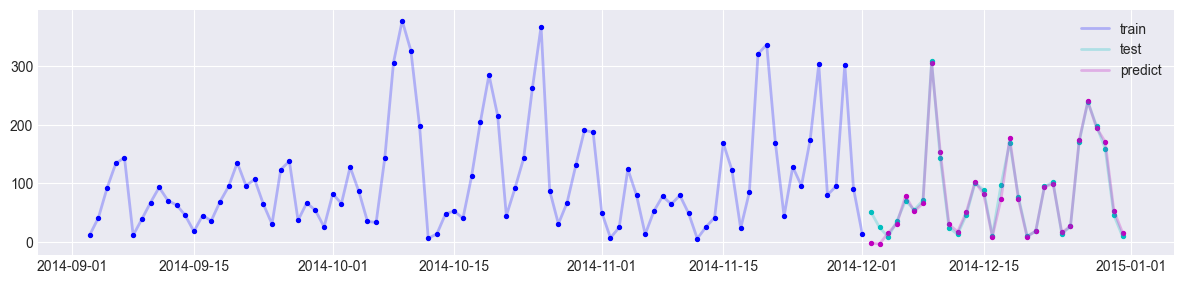

In [25]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [26]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [39]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,KNeighborsRegressor
mae,3.719444,3.946330,11.206154,8.875182,9.261864,7.436213,32.036411
rmse,14.803536,14.688406,16.627635,13.735031,13.374679,12.790585,44.403010
mape,0.100347,0.106267,0.338688,0.241541,0.238536,0.195747,0.928402
r2,0.960137,0.960754,0.949708,0.965684,0.967461,0.970241,0.641355


In [40]:
resultsDF.T

,mae,rmse,mape,r2
BayesianRidge,3.719444,14.803536,0.100347,0.960137
LassoCV,3.946330,14.688406,0.106267,0.960754
RandomForestRegressor,11.206154,16.627635,0.338688,0.949708
XGBRegressor,8.875182,13.735031,0.241541,0.965684
LGBMRegressor,9.261864,13.374679,0.238536,0.967461
CatBoostRegressor,7.436213,12.790585,0.195747,0.970241
KNeighborsRegressor,32.036411,44.403010,0.928402,0.641355


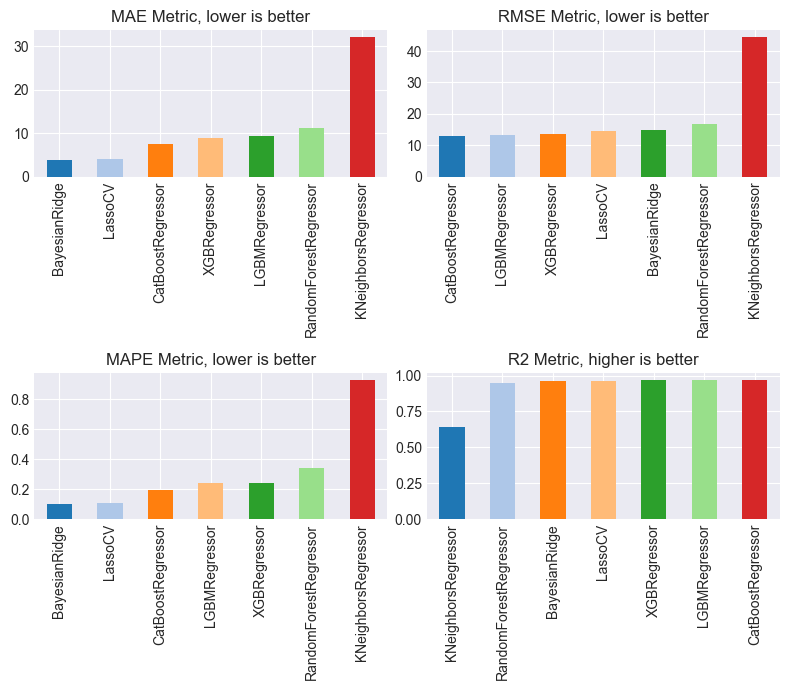

In [41]:
plot_metrics(resultsDF)